Basic informations about dataset:
The data contains information from the 1990 California census. So although it may not help you with predicting current housing prices like the Zillow Zestimate dataset, it does provide an accessible introductory dataset for teaching people about the basics of machine learning.


Size:
* number of features (columns): 10
* number of rows: 20640

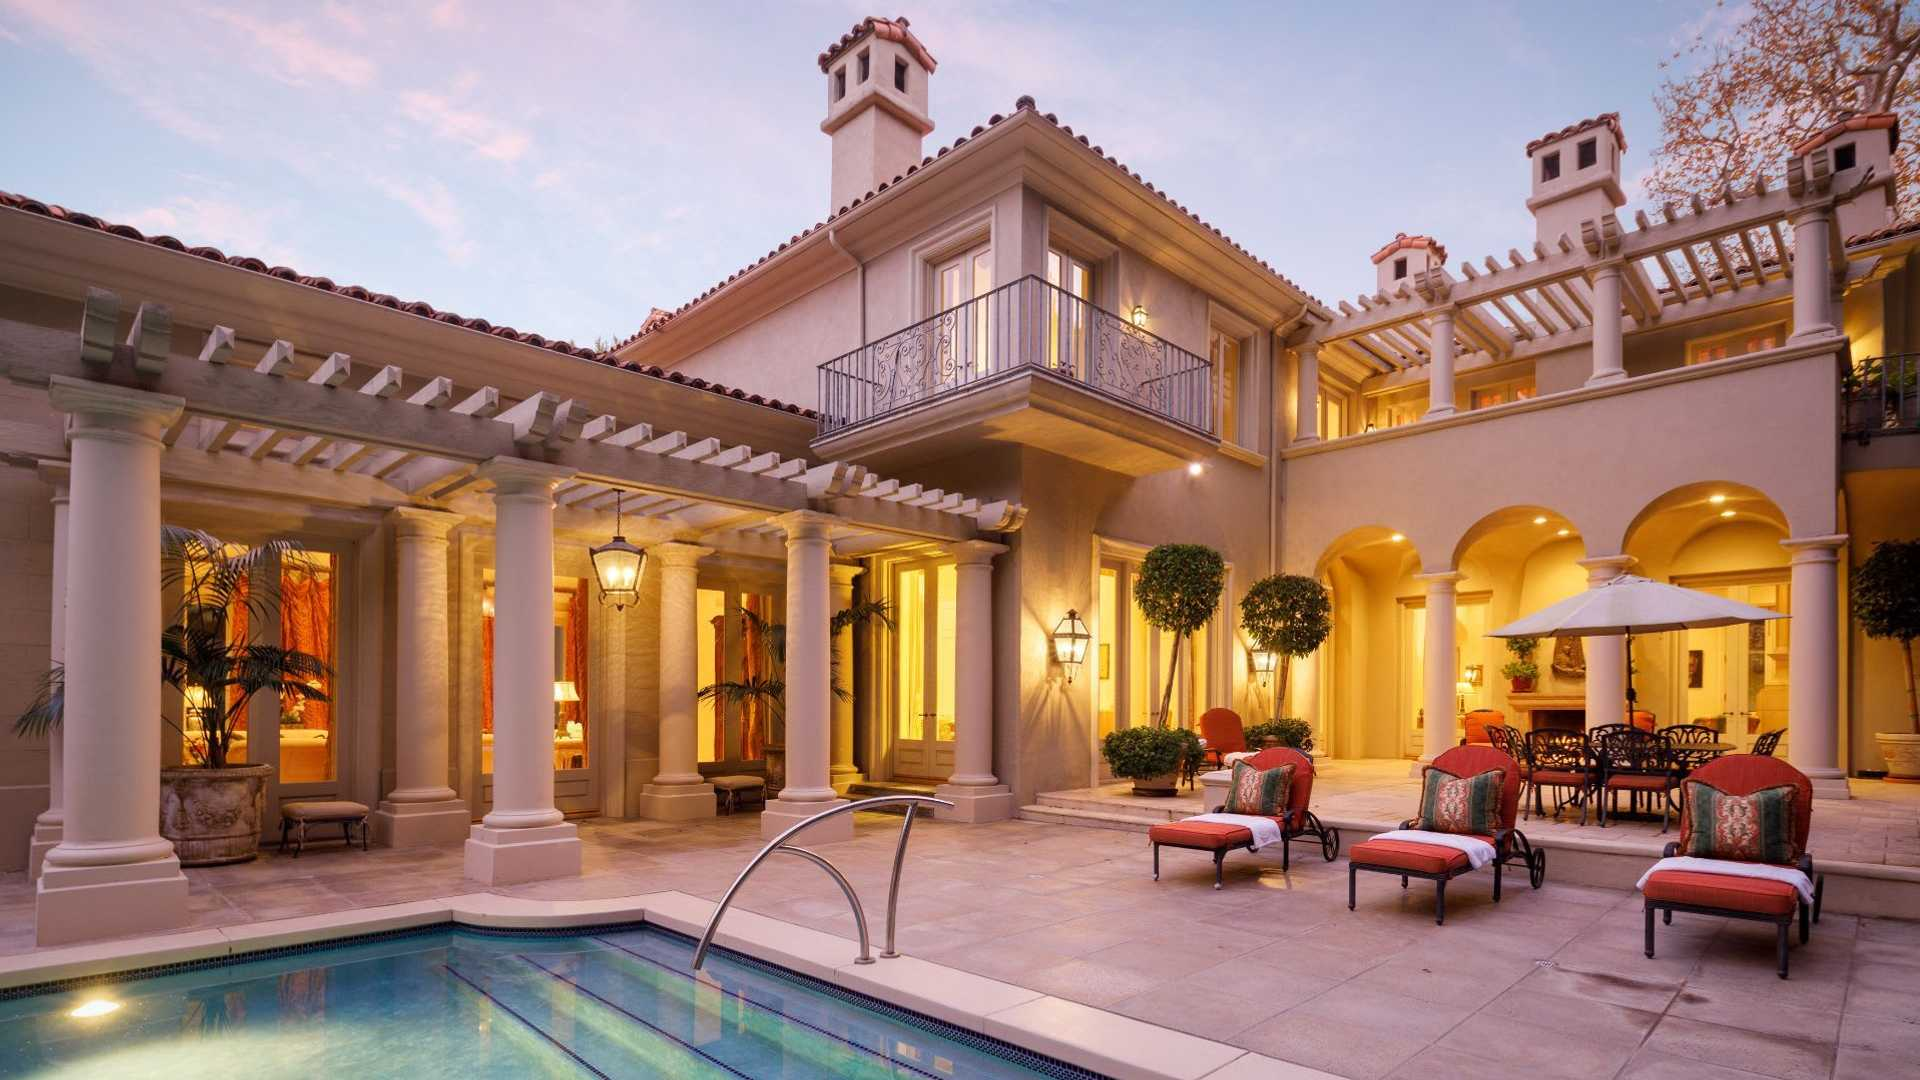
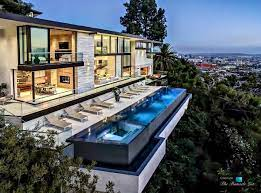

## 1. DATA PREPROCESSING

### 1.1 IMPORTING MODULES

In [51]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
sns.set(style="white")

import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)


from sklearn.neighbors import KNeighborsRegressor


df = pd.read_csv('../input/california-housing-prices/housing.csv')

### 1.2 DATA INSPECTING AND CLEANING

In [52]:
df.head() #  showing first 5 rows

In [53]:
df.describe() #  inspecting numerical features

In [54]:
df.info() #  showing information about datatypes

NULL VALUES

In [55]:
df.isnull().sum() #  null values for all features

## Housing distribution on the map

In [56]:
plt.figure(figsize=(16,6))
fig = sns.scatterplot(df.longitude, df.latitude, hue=df['median_house_value'],
                      legend=False, palette='winter');

Houses prices increases as well as ocean distance decreases - it's not big suprise. Houses with view on the ocean are mostly more expensive.

## 2. Data Imputation

*  there's only 207 null values in total_bedrooms
*  unsupervised learning approach - KNN (K-nst Nearest Neighbours) is gonna be useful to inpute data to dataframe

In [75]:
from sklearn.neighbors import KNeighborsRegressor


def input_knn(data_frame=df):
    
    """arguments: data_frame:pandas data frame - df default
         returns: data_frame with filled Nan values"""
    
    numeric_features = df.select_dtypes(include=[np.number]) #  only features with numeric values
    caterogical_features = df.select_dtypes(exclude=[np.number])  #  only features without numeric values
    nan_columns = numeric_features.columns[numeric_features.isna().any()].to_list() #  features with empty values (NaNs)
    no_nan_columns = numeric_features.columns.difference(nan_columns).values  #  features withouy empty values
    
    
    for column in nan_columns:
        imp_test = numeric_features[numeric_features[column].isna()] #  columns with null values 
        imp_train = numeric_features.dropna()
        model = KNeighborsRegressor(n_neighbors=5)
        knr = model.fit(imp_train[no_nan_columns], imp_train[column]) #  train model takes values from columns without null values
        numeric_features.loc[df[column].isna(), column] = knr.predict(imp_test[no_nan_columns]) #  KNR predicts replaces null values
        
    return pd.concat([numeric_features, caterogical_features], axis=1)

In [58]:
df_copy = df #  even if we have new df inputed with function above it's good practice to save old data frame
df=input_knn('total_bedrooms') #  imputing data
df.describe()

## 3. EDA

### 3.1 HISTOGRAMS

I'm going to inspect columns using **univeriate analysis** (analysis of only 1 variable). Histogram is good approach in this case. It allow us to see:

* data distribution
* otuliners
* odd patterns
* scale of axis

In [59]:
def plot_histogram(column_name, data_frame=df):
    
    """arguments: column_name:str - name of the column to be ploted
       returns: histogram object
    """
    
    #  in case when column is not in data frame
    if column_name not in data_frame.columns:
        raise ValueError(f'Chose correct column from data frame colums: {data_frame.columns}')
        
    fig = px.histogram(data_frame=data_frame.sort_values(by=column_name), x=column_name,
                       color_discrete_sequence=['blue'])
    
    
    fig.update_layout(font=dict(family='Lato', size=16), 
                      title=dict(text=f'<b>histogram - {column_name}<b>',
                                font=dict(size=24),
                                x=.5),
                     plot_bgcolor='lightblue',
                     paper_bgcolor='lightblue',
                     xaxis=dict(showgrid=False),
                     yaxis=dict(showgrid=False))
    
    fig.show()

In [60]:
numeric_columns = df.select_dtypes(np.number)
for column in numeric_columns:
    plot_histogram(column)

### Odd patterns and oustliners

At first glance:
* there's outliners at housing median age and median house value. It may be due to the way in which the data was sampled (median)
* housing median age has outliner at 52k, median house value at 500k

Less noticible:
* total rooms column cointans outliners. There's big part of houses distributed between 0 - 5k but there's some houses which have even 30k and more
* total bedrooms column contains otuliners. Mots of houses distributed in between 0 and 5k.
* pupulation and household contains outliners as well. Population is distributet mostly between 0 and 5k and household 0 and 1k

Dropping outliners from population column

In [61]:
df.sort_values(by='population', ascending=False)

In [62]:
df = df.drop(labels = [15360, 9880])
plot_histogram('population')
df.sort_values(by='population', ascending=False)

### Correlation

In [63]:
df.corr().style.background_gradient()

In [64]:
def correlation_heatmap(data_frame=df):
    """arguments: data_frame:pandas DataFrame
       returns: correlation heatmap"""
    
    #  setting the context
    sns.set(context='paper', font='moonspace')
    
    #  making correlation object and saving it into variable
    correlation = df.corr()
    
    #  creating heatmap figure object (paper) and ax object (the plot)
    fig, ax = plt.subplots(figsize=(12, 8))
    
    #  generating color palettes
    cmap = sns.diverging_palette(220, 10, center='light', as_cmap=True)
    
    #  draw the heatmap
    heatmap = sns.heatmap(correlation, vmax=1,vmin=-1,center=0, square=False, annot=True, cmap=cmap,
                         lw=2, cbar=False)
    
    return heatmap

In [65]:
correlation_heatmap();

*  target variable median_house_value is quite strong correlated to median_income variable
* there's no more strong correlations - we could consider dropping some features which are very weak correlated but in this case they will stay

## 4.Training Model

### 4.1 Linear Regression

In [66]:
from sklearn.model_selection import train_test_split

X = df.drop(['median_house_value', 'ocean_proximity'], axis=1)
y = df['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.33,
                                                   random_state=42)
#  splitting the data into train and test

In [67]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression() #  importing LinearRegression

reg.fit(X_train, y_train) #  fitting the train data frame and train feature to the LinearRegression

In [68]:
predictions=reg.predict(X_test)

Actual mean and predicted mean

In [69]:
print(f'actual: {y_test.mean()}')
print(f'predictions: {predictions.mean()}')

In [70]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print('MAE: ' + str(mean_absolute_error(y_test, predictions)))
print('MSE: ' + str(mean_squared_error(y_test, predictions)))
print('Score: '+ str(r2_score(y_test, predictions)))

### 4.2 Random Forest

In [71]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor() #  importing RandomForestRegressor

In [72]:
reg.fit(X_train, y_train) #  fitting train data and train feature

In [73]:
actual = y_test
predictions = reg.predict(X_test)
print(f'Actual mean: {np.mean(actual)}')
print(f'Predicted mean: {np.mean(predictions)}')

In [74]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print('MAE: ' + str(mean_absolute_error(y_test, predictions)))
print('MSE: ' + str(mean_squared_error(y_test, predictions)))
print('Score: '+ str(r2_score(y_test, predictions)))

## 5.Conclusions

Looks like RandomForestRegressor is the winner with score: 81